# Fruit Recognition

အရင်ဆုံး လိုတဲ့ package တွေကို ဖေါ်ပြထားပါတယ်။

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from skimage.color import rgb2gray
from skimage.transform import rescale, resize, downscale_local_mean
from sklearn.model_selection import train_test_split
from skimage import data, color, feature
from skimage.feature import hog

import glob

feature ဆွဲထုတ်ဖို့ HOG နဲ့ color descriptor ကို အသုံးပြုတယ်။

1. HOG (Histogram of Oriented Gradient)

    HOG အခြေခံကိုရှင်းပြပြီးဖြစ်တဲ့အတွက် skimage ရဲ့ hog ကို သုံးဖို့ဆိုရင် အောက်ပါ documentation ကိုကြည့်ပြီး အသုံးပြုပါမယ်။ 
    skimage.feature.hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3), block_norm='L2-Hys', visualize=False, transform_sqrt=False, feature_vector=True, multichannel=None)
    

In [35]:
def FtrExtractHOG(img):
    # Preprocessing may already produce grayscale; ensure HOG uses current API
    ftr,_ = hog(
        img,
        orientations=8,
        pixels_per_cell=(16, 16),
        cells_per_block=(1, 1),
        visualize=True
    )
    return ftr

2. Color Histogram

   Colour histogram ရရန်အတွက် RGB မှ HSV သို့ပြောင်းပါ။ ထို့နောက်အရောင်တစ်ခုစီ၏ histogram ကိုဖန်တီးပါ။ ထို့နောက် histogram concatenate လုပ်ပါ။
   

In [15]:
def FtrExtractColorHist(img):
    chans = cv2.split(img)
    colors = ("h", "s", "v")
    features = []

    for (chan, color) in zip(chans, colors):
        hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
        features.extend(hist)
    return np.array(features).flatten()

recognize မလုပ်ခင် acquisition လုပ်မယ်။

In [6]:
# Fixed fruit recognition pipeline (aligned with .py scripts)
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.transform import resize
from skimage.feature import hog
import glob
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


def preProcessing(arr):
    arr_pre = []
    for i in range(len(arr)):
        img = cv2.cvtColor(arr[i], cv2.COLOR_BGR2GRAY)
        img = resize(img, (72, 72), anti_aliasing=True)
        arr_pre.append(img)
    return arr_pre


def featureExtractionHOG(img):
    # skimage.hog no longer uses 'multichannel'; images are grayscale
    ftr = hog(
        img,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        visualize=False,
    )
    return ftr


def featureExtraction(arr):
    arr_feature = []
    for i in range(len(arr)):
        arr_feature.append(featureExtractionHOG(arr[i]))
    return arr_feature


def loadImage(arr, n, name_of_fruit):
    label = []
    for i in range(n):
        strr = "rgb/" + name_of_fruit + "_" + str(i + 1) + "/*.png"
        for file in glob.glob(strr):
            img = plt.imread(file)
            arr.append(img)
            label.append(name_of_fruit)
    return arr, label

# Load dataset
apple = []
banana = []
lemon = []
lime = []
orange = []
peach = []
pear = []

apple, label_apple = loadImage(apple, 5, "apple")
banana, label_banana = loadImage(banana, 4, "banana")
lemon, label_lemon = loadImage(lemon, 6, "lemon")
lime, label_lime = loadImage(lime, 4, "lime")
orange, label_orange = loadImage(orange, 4, "orange")
peach, label_peach = loadImage(peach, 3, "peach")
pear, label_pear = loadImage(pear, 3, "pear")

raw_attrib = {
    "class": ["Apple", "Banana", "Lemon", "Lime", "Orange", "Peach", "Pear"],
    "amount": [
        len(apple),
        len(banana),
        len(lemon),
        len(lime),
        len(orange),
        len(peach),
        len(pear),
    ],
}
attrib = pd.DataFrame(raw_attrib, columns=["class", "amount"])

# Keep as lists to avoid ragged array issues
total_x = apple + banana + lemon + lime + orange + peach + pear
total_y = (
    label_apple
    + label_banana
    + label_lemon
    + label_lime
    + label_orange
    + label_peach
    + label_pear
)

x_train, x_test, y_train, y_test = train_test_split(
    total_x, total_y, test_size=0.33, random_state=42
)

print("training amount :", len(x_train))
print("testing amount  :", len(x_test))

x_train_pre = preProcessing(x_train)
x_test_pre = preProcessing(x_test)

print("Finished preprocessing!")

x_train_feature = featureExtraction(x_train_pre)
x_test_feature = featureExtraction(x_test_pre)

print("Finished feature extraction!")

clf = KNeighborsClassifier(n_jobs=-1, weights="distance", n_neighbors=11)
clf.fit(x_train_feature, y_train)

print("Training finished!")

y_knn_predict = clf.predict(x_test_feature)
print(accuracy_score(y_test, y_knn_predict) * 100, "%")
print("Predict finished!")


training amount : 12815
testing amount  : 6312
Finished preprocessing!
Finished feature extraction!
Training finished!
100.0 %
Predict finished!


In [16]:
len(apple)

3098

In [17]:
raw_atribut = {'Kelas': ['Apple','Banana','Lemon','Lime','Orange', 'Pear', 'Peach'],
           'Jumlah': [len(apple),len(banana),len(lemon),len(lime),len(orange),len(peach),len(pear)]}
atribut= pd.DataFrame(raw_atribut,
                       columns=['Kelas','Jumlah'])
atribut

,Kelas,Jumlah
0,Apple,3098
1,Banana,2826
2,Lemon,3747
3,Lime,2514
4,Orange,2834
5,Pear,2082
6,Peach,2026


Datasets စုစုပေါင်း image က ၁၉၁၂၇ ဖြစ်ပြီး အဲ့ဒီထဲက ပထမဆုံး image တွေကိုကြည့်ရအောင်။

Contoh Dataset


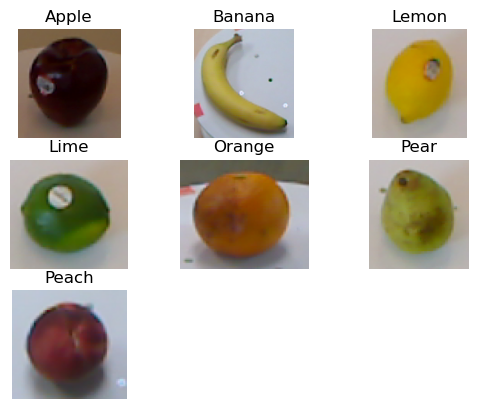

In [18]:
print('Contoh Dataset')
fig = plt.figure()
ax1 = fig.add_subplot(3,3,1)
ax1.set_title('Apple')
ax1.set_axis_off()
ax1.imshow(apple[0])

ax2 = fig.add_subplot(3,3,2)
ax2.set_title('Banana')
ax2.set_axis_off()
ax2.imshow(banana[0])

ax3 = fig.add_subplot(3,3,3)
ax3.set_title('Lemon')
ax3.set_axis_off()
ax3.imshow(lemon[0])

ax4 = fig.add_subplot(3,3,4)
ax4.set_title('Lime')
ax4.set_axis_off()
ax4.imshow(lime[0])

ax5 = fig.add_subplot(3,3,5)
ax5.set_title('Orange')
ax5.set_axis_off()
ax5.imshow(orange[0])

ax6 = fig.add_subplot(3,3,6)
ax6.set_title('Pear')
ax6.set_axis_off()
ax6.imshow(pear[0])

ax7 = fig.add_subplot(3,3,7)
ax7.set_title('Peach')
ax7.set_axis_off()
ax7.imshow(peach[0])

### Machine Learning Algorithms ၏ဖော်ပြချက်
knn သုံးပြီးအောက်ပါအတိုင်းတည်ဆောက်မယ်။

<img src='Block_Diagram.png' width=120px>

ပထမ ဦး စွာပုံကိုအရင်ထည့်ပါ။ ထို့နောက် preprocessing ကိုလုပ်ပါ။ ပြီးရင် feature ဆွဲထုတ်ပြီးနောက်နောက်တစ်ဆင့်အနေဖြင့် Datasets ကိုအပိုင်းနှစ်ပိုင်းခွဲခြားရန်ဖြစ်သည်။ အချက်အလက်များကိုလေ့ကျင့်သင်ကြားမှုကို ၆၇% နှင့်ဒေတာများကိုစမ်းသပ်မှုအတွက် ၃၃% ဖြင့်ခွဲမည်။

In [30]:
def preprocessing1(arr):
    arr_prep=[]
    for i in range(len(arr)):
        img=cv2.cvtColor(arr[i], cv2.COLOR_BGR2GRAY)
        img=resize(img, (72, 72),anti_aliasing=True)
        arr_prep.append(img)
    return arr_prep

In [36]:
def featureExtraction1(arr):
    arr_feature=[]
    for i in range(len(arr)):
        arr_feature.append(FtrExtractHOG(arr[i]))
    return arr_feature

In [26]:
#Save DataTrain and the label
X_Shapedes = apple + banana + lemon + lime + orange + peach + pear
y_Shapedes = label_apple + label_banana + label_lemon + label_lime + label_orange + label_peach + label_pear

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_Shapedes, y_Shapedes, test_size=0.33, random_state=42)

In [28]:
print('Jumlah Data Train :', len(X_train))
print('Jumlah Data Test  :', len(X_test))

Jumlah Data Train : 12815
Jumlah Data Test  : 6312


In [33]:
#Preprocessing
X_trainp=preprocessing1(X_train)
X_testp=preprocessing1(X_test)

In [37]:
#Feature Extraction
X_trainftr=featureExtraction1(X_trainp)
X_testftr=featureExtraction1(X_testp)

In [38]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
knn_clf = KNeighborsClassifier(n_jobs=-1, weights='distance', n_neighbors=11)
knn_clf.fit(X_trainftr, y_train)

,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",11
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'distance'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"p p: float, default=2Power parameter for the Minkowski metric. When p = 1, this is equivalentto using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.For arbitrary p, minkowski_distance (l_p) is used. This parameter is expectedto be positive.",2
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'minkowski'
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.Doesn't affect :meth:`fit` method.",-1


In [39]:
y_knn_pred = knn_clf.predict(X_testftr)

In [40]:
print(accuracy_score(y_test, y_knn_pred)*100,'%')

99.95247148288973 %


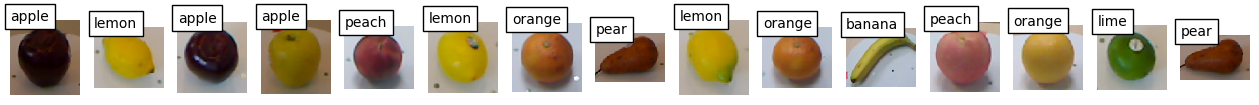

In [41]:
slice = 15

plt.figure(figsize=(16,8))
for i in range(slice):
    plt.subplot(1, slice, i+1)
    plt.imshow(X_test[i], interpolation='nearest')
    plt.text(0, 0, y_knn_pred[i], color='black', 
             bbox=dict(facecolor='white', alpha=1))
    plt.axis('off')

#### အရောင်ဖော်ပြချက်
ပထမအဆင့်ကတော့ပုံကိုအရင်လုပ်ဖို့ဖြစ်တယ်။ ကောင်းမွန်သောဖော်ထုတ်မှုရလဒ်များရရှိရန်အတွက်ရုပ်ပုံများကို RGB မှ HSV သို့ပြောင်းလဲခြင်းဖြင့်ပြုလုပ်နိုင်သည်။

In [42]:
def preprocessing2(arr):
    arr_prep=[]
    for i in range(len(arr)):
        img=matplotlib.colors.rgb_to_hsv(arr[i])
        arr_prep.append(img)
    return arr_prep

In [43]:
def featureExtraction2(arr):
    arr_feature=[]
    for i in range(len(arr)):
        arr_feature.append(FtrExtractColorHist(arr[i]))
    return arr_feature

In [44]:
#Save DataTrain and the label
X_Colordes = apple + banana + lemon + lime + orange + peach + pear
y_Colordes = label_apple + label_banana + label_lemon + label_lime + label_orange + label_peach + label_pear

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X_Colordes, y_Colordes, test_size=0.33, random_state=42)

In [46]:
print('Jumlah Data Train : ', len(X_train))
print('Jumlah Data Test  :', len(X_test))

Jumlah Data Train :  12815
Jumlah Data Test  : 6312


In [47]:
#Preprocessing
X_trainp=preprocessing2(X_train)
X_testp=preprocessing2(X_test)

In [48]:
#Feature Extraction
X_trainftr=featureExtraction2(X_trainp)
X_testftr=featureExtraction2(X_testp)

In [49]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
knn_clf = KNeighborsClassifier(n_jobs=-1, weights='distance', n_neighbors=11)
knn_clf.fit(X_trainftr, y_train)

,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",11
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'distance'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"p p: float, default=2Power parameter for the Minkowski metric. When p = 1, this is equivalentto using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.For arbitrary p, minkowski_distance (l_p) is used. This parameter is expectedto be positive.",2
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'minkowski'
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.Doesn't affect :meth:`fit` method.",-1


In [50]:
y_knn_pred = knn_clf.predict(X_testftr)

In [51]:
print(accuracy_score(y_test, y_knn_pred)*100,'%')

89.63878326996198 %


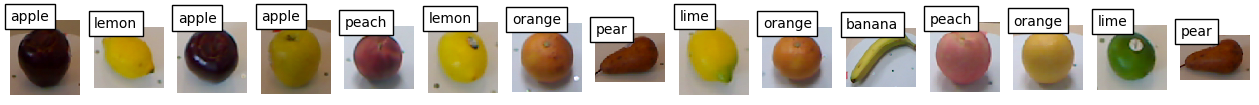

In [52]:
slice = 15

plt.figure(figsize=(16,8))
for i in range(slice):
    plt.subplot(1,slice , i+1)
    plt.imshow(X_test[i], interpolation='nearest')
    plt.text(0, 0, (y_knn_pred[i]), color='black', 
             bbox=dict(facecolor='white', alpha=1))
    plt.axis('off')